In [1]:
import tensorflow
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Flatten, Conv2D, Dense, Conv2DTranspose, Reshape, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# mnist dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

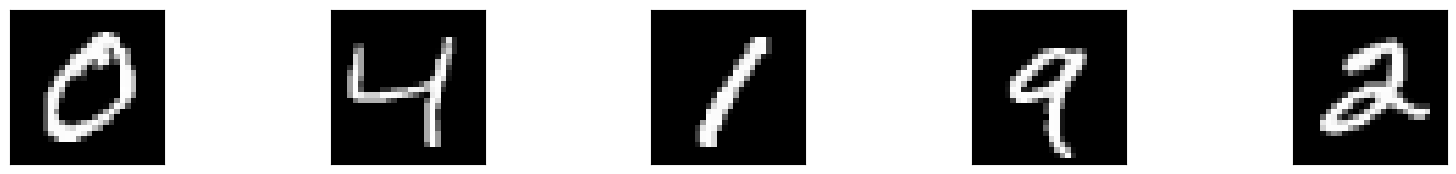

In [18]:
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### preprocessing

In [12]:
x_train = x_train.astype('float')/255
x_test = x_test.astype('float')/255

In [13]:
x_train[0][20][:20]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09411765, 0.44705882, 0.86666667, 0.99215686, 0.99215686,
       0.99215686, 0.99215686, 0.78823529, 0.30588235, 0.        ])

In [14]:
x_train_preprocessed = np.expand_dims(x_train, axis=-1)
x_test_preprocessed = np.expand_dims(x_test, axis=-1)
x_train_preprocessed.shape

(60000, 28, 28, 1)

#generate noisy data

In [15]:
noise_factor = 0.7
x_train_noisy = x_train_preprocessed + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_preprocessed.shape)
x_test_noisy = x_test_preprocessed + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_preprocessed.shape)

# Clip the pixel values to be in the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

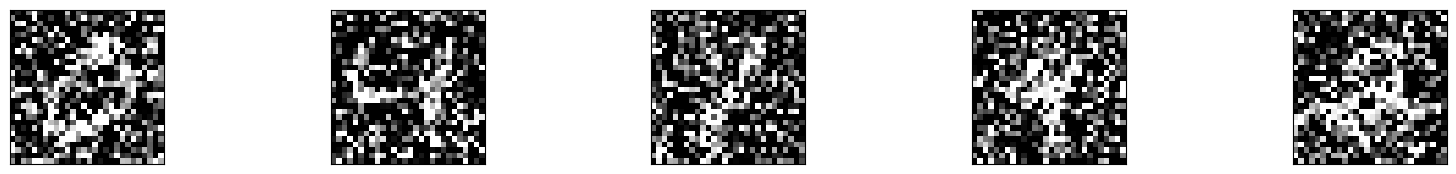

In [16]:
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### code for encoder

#### The architecture using the Functional API

In [19]:
encoder_input = Input(shape = (28,28,1))
conv_1 = Conv2D(32, 3, strides=2, padding='SAME')(encoder_input)
# conv_1 = MaxPooling2D(2, padding='SAME')(conv_1)
conv_2 = Conv2D(64, 3, strides=2, padding='SAME')(conv_1)
# encoder_output = MaxPooling2D(2, padding='SAME')(conv_2)
flatten = Flatten()(conv_2)
encoder_output = Dense(2, activation= 'relu', kernel_initializer='he_normal')(flatten)

In [20]:
Model(encoder_input, encoder_output).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 2)                 6274      
                                                                 
Total params: 25090 (98.01 KB)
Trainable params: 25090 (98.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### decoder

#### code for decoder using Functional API

In [21]:
decoder_input = Dense(7*7*64, activation= 'relu')(encoder_output)
reshape = Reshape((7,7,64))(decoder_input)
conv_T1 = Conv2DTranspose(64, 3, strides=2, padding='SAME', activation='relu')(reshape)
conv_T2 = Conv2DTranspose(32, 3, strides=2, padding='SAME', activation='relu')(conv_T1)
decoder_output = Conv2DTranspose(1,3, padding='SAME', activation= 'sigmoid')(conv_T2)

In [22]:
Model(decoder_input, decoder_output).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3136)]            0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289       
 Transpose)                                                      
                                                           

#### Autoencoder model

In [23]:
autoEncoder = Model(encoder_input, decoder_output)
optimizer = keras.optimizers.Adam(learning_rate=0.01)
autoEncoder.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= 'accuracy')

In [24]:
autoEncoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 2)                 6274      
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0   

In [25]:
autoEncoder.fit(x_train_noisy, x_train_preprocessed, epochs=10, shuffle=True, validation_data = (x_test_noisy, x_test_preprocessed), batch_size=128)

Epoch 1/10
469/469 [==============================] - 11s 11ms/step - loss: 0.2710 - accuracy: 0.8030 - val_loss: 0.2348 - val_accuracy: 0.7888
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2289 - accuracy: 0.7932 - val_loss: 0.2260 - val_accuracy: 0.7935
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2252 - accuracy: 0.7945 - val_loss: 0.2238 - val_accuracy: 0.7932
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2243 - accuracy: 0.7951 - val_loss: 0.2253 - val_accuracy: 0.7899
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2238 - accuracy: 0.7955 - val_loss: 0.2235 - val_accuracy: 0.7906
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2236 - accuracy: 0.7956 - val_loss: 0.2229 - val_accuracy: 0.7950
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2234 - accuracy: 0.7958 - val_loss: 0.2226 - val_accuracy: 0.7955
Epoc

In [26]:
y_pred = autoEncoder.predict(x_test_noisy)

313/313 [==============================] - 1s 2ms/step


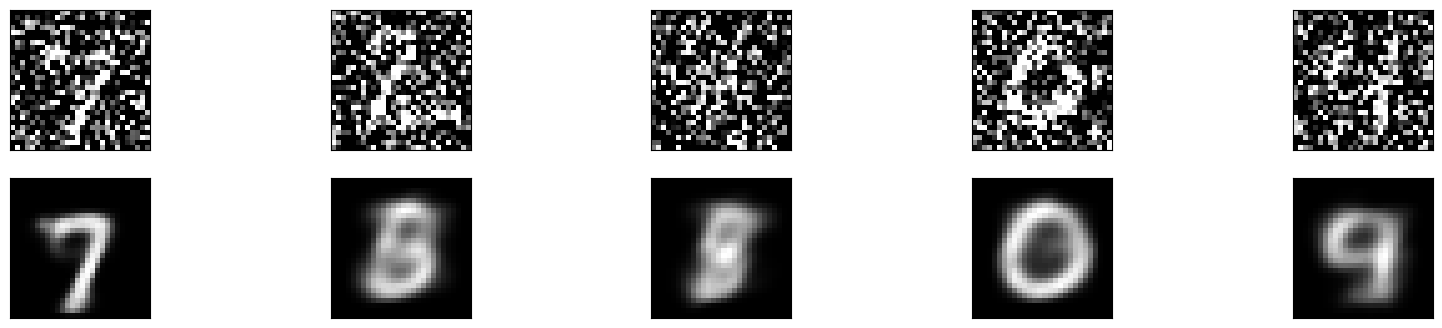

In [27]:
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(y_pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()